<a href="https://colab.research.google.com/github/me-t1me/Bilateral_relation_paper/blob/master/Bilateral_relation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nsepy 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_white
import pandas_datareader as pdr
import datetime
import re

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for nsepy: filename=nsepy-0.8-py3-none-any.whl size=36085 sha256=1922762ea7fd8f127599c8a4ea3c2f2285b8b38a5870bce0a8f72f341f676a99
  Stored in directory: /root/.cache/pip/wheels/b9/2c/cb/d74199e422a1dbc20297d10cfff9c54d03e0b5c6694d49ccdd
Successfully built nsepy


# Data cleaning and processing
returns data: cleaned and processed pandas dataframe


In [2]:
df = pd.read_excel("https://github.com/me-t1me/Bilateral_relation_paper/blob/master/Data_relation.xlsx?raw=true")

In [3]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Company,Company Type,Industry,Sector,Amount(US$M),Amount(INR Cr),Round,Stage,...,Valuation,Revenue (INR Cr),EBITDA (INR Cr),PAT (INR Cr),Total Debt (INR Cr),Cash & Cash Equ. (INR Cr),Book Value Per Share,Price Per Share,Link for Financials,Sentiment
0,0.0,0.0,Apeirogon,Unlisted,IT & ITES,Online Services (E-Learning & Test Preparation),0.68,5.00,Seed,Early,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1.0,1.0,Artivatic.ai,Unlisted,IT & ITES,Enterprise Software (Artificial Intelligence -...,NaN,NaN,Bridge-Seed,Early,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2.0,2.0,Arya Collateral,Unlisted,Agri-business,Agri Logistics,21.00,NaN,NaN,Late,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,3.0,3.0,Atomberg Technologies,Unlisted,Manufacturing,Consumer Durables (Household Electrical Applia...,9.42,69.71,2.0,Growth,...,Revenue Multiple based on FY19 financials.,37.26,-6.05,-6.48,NaN,NaN,NaN,158909.0,NaN,1.0
4,4.0,4.0,AU Small Finance Bank,Listed,BFSI,Banking (Small Finance Bank),73.67,542.27,NaN,PIPE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [4]:
needed_col = ['Industry', 'Amount(US$M)', 'Stage', 'Investor Type', 'Date', 'Year Founded', 'State', 'Post Money Valuation (INR Cr)', 'Sentiment']

In [5]:
regdata = df.loc[:, needed_col]

In [6]:
regdata = regdata.dropna()

In [7]:
len(regdata)

8660

In [8]:
regdata = regdata[regdata['Amount(US$M)'] != 0] 
regdata['funding'] = np.log(regdata['Amount(US$M)'])

In [9]:
regdata['Year'] = pd.to_datetime(regdata['Date'], format='%b-%y').dt.year

In [10]:
def remove_bad(x):
  try:
    return int(x)
  except:
    return 0

In [11]:
regdata['Year Founded'] = regdata['Year Founded'].apply(remove_bad)

In [12]:
regdata['Year Founded'].unique()

array([2012, 2011, 2020, 2015, 2017, 2010, 2018, 2019, 2009, 2016, 1930,
       2014, 1985, 2003, 1993, 2013, 1998, 1994, 1974, 1980, 1997, 2008,
       2004, 1982, 2007, 2001, 1991, 1987, 1990, 1978, 2000, 1957, 1996,
       2005, 2006, 1999, 1988, 1995, 1984, 1942, 2002, 1986, 1973, 1989,
       1992, 1929, 1983, 1964, 1948,    0, 1981, 1916, 1943, 1979, 1977,
       1909, 1965, 1963, 1976, 1931, 1936, 1971, 1904, 1949, 1918, 1955,
       1970, 1951, 1952, 1947, 1972, 1917, 1968, 1019, 1975, 1969, 1922,
       1956, 1953, 1875, 1967,    4, 1902, 1961, 1937, 1934, 1959, 1958,
       1950, 1935, 1938, 1926, 1962, 1945, 1920, 1966, 1960, 1924, 1826,
       1939, 1944, 1884, 1905, 1946, 1881])

In [13]:
regdata['age'] = regdata['Year'].astype(np.int32) - regdata['Year Founded'].astype(np.int32) + 1

In [14]:
regdata = regdata[regdata['age'] > 0]

In [15]:
start_date = datetime.datetime(2004, 1, 1)
end_date = datetime.datetime(2020, 12, 31)
exchange_rates = pdr.DataReader('DEXINUS', 'fred', start_date, end_date)
exchange_rates

,DEXINUS
DATE,
2004-01-01,NaN
2004-01-02,45.68
2004-01-05,45.60
2004-01-06,45.66
2004-01-07,45.53
...,...
2020-12-25,NaN
2020-12-28,73.50
2020-12-29,73.33


In [16]:
exchange_rates = exchange_rates.dropna()

In [17]:
exchange_rates.index = exchange_rates.index.strftime('%b-%y')

In [18]:
exchange_rates = exchange_rates[~exchange_rates.index.duplicated(keep='first')]

In [19]:
regdata['exchange_rates'] = None

In [20]:
for i in regdata.index:
  regdata['exchange_rates'][i] = exchange_rates['DEXINUS'][regdata['Date'][i]]

<ipython-input-20-842fbc435bac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regdata['exchange_rates'][i] = exchange_rates['DEXINUS'][regdata['Date'][i]]


In [21]:
def clean_currency(x):
    if isinstance(x, str):
        return(x.replace(',', ''))
    return(x)

In [22]:
regdata['Post Money Valuation (INR Cr)'] = regdata['Post Money Valuation (INR Cr)'].apply(clean_currency).astype('float')

In [23]:
regdata['valuation'] = np.log(((regdata['Post Money Valuation (INR Cr)'] * 10 ) / regdata['exchange_rates']).astype(float))

In [24]:
def get_stage_dummy(x):
  if x == "Early":
    return 1
  
  return 0

In [25]:
regdata['Early'] = regdata['Stage'].apply(get_stage_dummy)

In [26]:
regdata.head()

,Industry,Amount(US$M),Stage,Investor Type,Date,Year Founded,State,Post Money Valuation (INR Cr),Sentiment,funding,Year,age,exchange_rates,valuation,Early
3,Manufacturing,9.42,Growth,India-dedicated,Dec-20,2012,Maharashtra,432.82,1.0,2.242835,2020,9,73.51,4.075486,0
13,Education,40.00,Growth-PE,Co-Investment,Dec-20,2011,Karnataka,1263.19,1.0,3.688879,2020,10,73.51,5.146559,0
18,IT & ITES,5.43,Growth,India-dedicated,Dec-20,2011,Karnataka,205.60,1.0,1.691939,2020,10,73.51,3.331096,0
36,IT & ITES,0.75,Early,India-dedicated,Dec-20,2020,Maharashtra,28.00,1.0,-0.287682,2020,1,73.51,1.337368,1
38,IT & ITES,3.00,Early,Foreign,Dec-20,2015,Maharashtra,311.75,1.0,1.098612,2020,6,73.51,3.747365,1


In [27]:
inflation = {	
     2012:	11.17, 
     2011:	6.49 , 
     2020:	3.69 ,
     2010:	9.47 , 
     2019:	9.63 ,
     2009:	14.97,
     2018:	5.24 ,	 	
     2008:	9.70 , 
     2017:	4.00 ,	 	
     2007:	5.51 , 
     2016:	2.23 ,	 	
     2006:	6.53 , 
     2015:	6.32 ,	 	
     2005:	5.57 , 
     2014:	5.86 ,	 	
     2004:	3.78 , 
     2013:	9.13 ,	
    } 

regdata["inflation"] = None
for i in regdata.index:
  regdata["inflation"][i] = np.log(inflation[regdata["Year"][i]]).astype(float)

regdata.head()

<ipython-input-27-27f69ffdc747>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regdata["inflation"][i] = np.log(inflation[regdata["Year"][i]]).astype(float)


,Industry,Amount(US$M),Stage,Investor Type,Date,Year Founded,State,Post Money Valuation (INR Cr),Sentiment,funding,Year,age,exchange_rates,valuation,Early,inflation
3,Manufacturing,9.42,Growth,India-dedicated,Dec-20,2012,Maharashtra,432.82,1.0,2.242835,2020,9,73.51,4.075486,0,1.305626
13,Education,40.00,Growth-PE,Co-Investment,Dec-20,2011,Karnataka,1263.19,1.0,3.688879,2020,10,73.51,5.146559,0,1.305626
18,IT & ITES,5.43,Growth,India-dedicated,Dec-20,2011,Karnataka,205.60,1.0,1.691939,2020,10,73.51,3.331096,0,1.305626
36,IT & ITES,0.75,Early,India-dedicated,Dec-20,2020,Maharashtra,28.00,1.0,-0.287682,2020,1,73.51,1.337368,1,1.305626
38,IT & ITES,3.00,Early,Foreign,Dec-20,2015,Maharashtra,311.75,1.0,1.098612,2020,6,73.51,3.747365,1,1.305626


In [28]:
from nsepy import get_history
from datetime import date
import pandas as pd

# Define the start and end dates
start_date = date(2004, 1, 1)
end_date = date(2020, 12, 31)

# Download the historical data for NIFTY 50
nifty_data = get_history(symbol='NIFTY 50', start=start_date, end=end_date, index=True)


# # Calculate the market capitalization for each day
nifty_data['Market Cap'] = nifty_data['Close'] * nifty_data['Volume']

nifty_data.index = pd.to_datetime(nifty_data.index, format='%Y-%m-%d')

nifty_monthly = nifty_data.resample('M')['Market Cap'].sum()

nifty_monthly.index = nifty_monthly.index.strftime('%b-%y')
# Print the monthly market capitalization


In [29]:
regdata['mkt_cap'] = None

for i in regdata.index:
  date = regdata['Date'][i]
  ex = exchange_rates['DEXINUS'][date]
  regdata['mkt_cap'][i] = np.log(nifty_monthly[date] / (ex *  1000000))

<ipython-input-29-97fa81d3b4ad>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regdata['mkt_cap'][i] = np.log(nifty_monthly[date] / (ex *  1000000))


In [30]:
regdata = regdata[regdata['Investor Type'] != 'Unknown']

In [31]:
data = pd.get_dummies(regdata, columns=['Investor Type', 'State', 'Industry', 'Date']) 

In [32]:
data.drop(columns=['Amount(US$M)', 'Stage', 'Year Founded', 'Post Money Valuation (INR Cr)', 'Year', 'exchange_rates'], inplace=True)

In [33]:
data.reset_index(drop=True, inplace=True)

# Regression

In [34]:
data.head()

,Sentiment,funding,age,valuation,Early,inflation,mkt_cap,Investor Type_Co-Investment,Investor Type_Foreign,Investor Type_India-dedicated,...,Date_Sep-11,Date_Sep-12,Date_Sep-13,Date_Sep-14,Date_Sep-15,Date_Sep-16,Date_Sep-17,Date_Sep-18,Date_Sep-19,Date_Sep-20
0,1.0,2.242835,9,4.075486,0,1.305626,14.612732,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1.0,3.688879,10,5.146559,0,1.305626,14.612732,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1.691939,10,3.331096,0,1.305626,14.612732,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1.0,-0.287682,1,1.337368,1,1.305626,14.612732,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1.098612,6,3.747365,1,1.305626,14.612732,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
data.describe()

,Sentiment,funding,age,valuation,Early,Investor Type_Co-Investment,Investor Type_Foreign,Investor Type_India-dedicated,State_Andhra Pradesh,State_Assam,...,Date_Sep-11,Date_Sep-12,Date_Sep-13,Date_Sep-14,Date_Sep-15,Date_Sep-16,Date_Sep-17,Date_Sep-18,Date_Sep-19,Date_Sep-20
count,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.00000,8622.000000,8622.000000,...,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000
mean,0.650743,1.655078,14.306889,3.497377,0.377059,0.278474,0.234516,0.48701,0.002900,0.001044,...,0.004755,0.005103,0.005335,0.005335,0.009279,0.004755,0.004639,0.011018,0.008583,0.003827
std,0.394941,1.823889,77.515619,1.939825,0.484678,0.448274,0.423721,0.49986,0.053773,0.032294,...,0.068798,0.071258,0.072851,0.072851,0.095883,0.068798,0.067958,0.104394,0.092250,0.061751
min,-0.999244,-4.605170,1.000000,-2.896526,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.249118,0.431782,3.000000,2.095932,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.691939,6.000000,3.410891,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.854598,14.000000,4.821459,1.000000,1.000000,0.000000,1.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,9.197400,2019.000000,11.079346,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Correlation

In [36]:
data['Sentiment'].describe(), data['funding'].describe()

(count    8622.000000
 mean        0.650743
 std         0.394941
 min        -0.999244
 25%         0.249118
 50%         1.000000
 75%         1.000000
 max         1.000000
 Name: Sentiment, dtype: float64, count    8622.000000
 mean        1.655078
 std         1.823889
 min        -4.605170
 25%         0.431782
 50%         1.691939
 75%         2.854598
 max         9.197400
 Name: funding, dtype: float64)

In [37]:
corr_mat = data[['Sentiment', 'funding']].corr()
corr_mat

,Sentiment,funding
Sentiment,1.000000,-0.265964
funding,-0.265964,1.000000


<AxesSubplot:xlabel='Sentiment', ylabel='funding'>

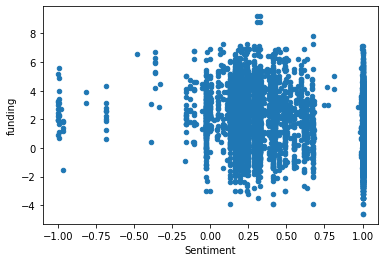

In [38]:
data.plot.scatter(x='Sentiment', y='funding')  # Create scatter plot

In [39]:
data1 = data[data['Sentiment'] != 1]

In [40]:
corr_mat1 = data1[['Sentiment', 'funding']].corr()
corr_mat1 

,Sentiment,funding
Sentiment,1.000000,-0.047033
funding,-0.047033,1.000000


<AxesSubplot:xlabel='Sentiment', ylabel='funding'>

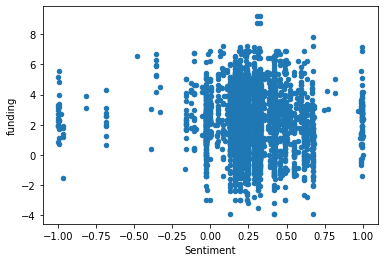

In [41]:
data1.plot.scatter(x='Sentiment', y='funding')

## First Model
X = Sentiment

Y = funding

In [42]:
X, Y = data['Sentiment'], data['funding']

In [43]:
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()  
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                funding   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     656.2
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          1.54e-139
Time:                        13:22:05   Log-Likelihood:                -17099.
No. Observations:                8622   AIC:                         3.420e+04
Df Residuals:                    8620   BIC:                         3.422e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4544      0.036     67.245      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### 2nd column
X = Sentiment

Y = funding, state, industry, time

In [44]:
X = data.drop(['funding', 'age', 'valuation','Early','inflation','mkt_cap','Investor Type_Co-Investment','Investor Type_Foreign','Investor Type_India-dedicated'], axis = 1)
Y = data["funding"]

In [45]:
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()  
print(model.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                funding   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     8.150
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          4.04e-240
Time:                        13:22:06   Log-Likelihood:                -16483.
No. Observations:                8622   AIC:                         3.346e+04
Df Residuals:                    8373   BIC:                         3.522e+04
Df Model:                         248                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

### 3rd column
X = Sentiment

Y = funding, state, industry, time, age, mkt_cap, inflation, early, valuation

In [46]:
X = data.drop('funding', axis=1)
Y = data["funding"]

In [47]:
X = sm.add_constant(X)
model = sm.OLS(Y, X.astype(float)).fit()  
print(model.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                funding   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     95.65
Date:                Thu, 02 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:22:07   Log-Likelihood:                -11557.
No. Observations:                8622   AIC:                         2.362e+04
Df Residuals:                    8368   BIC:                         2.542e+04
Df Model:                         253                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co